In [43]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from kmodes.kmodes import KModes
from pprint import pprint

# supress warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
!ls | grep .csv

predict.csv
training.csv


In [4]:
train_df = pd.read_csv('training.csv')
train_orig_df = train_df.copy()
pred_df = pd.read_csv('predict.csv')
train_df.head()

,id,posted_time,updated_time,age,updated_age,app_type,owner_id,owner_type,owner_influence,number_of_likes,...,participant5_id,participant5_action,participant5_gender,participant5_is_employee,participant5_is_lead,participant5_is_in_connections,participant5_focus,participant5_order,participant5_influence,rank
0,175339,1.514050e+12,1.514050e+12,6.315242e+10,6.315242e+10,other,57727,space,0.99973,1,...,3089,viewed,male,0,0,1,other,1,0.23077,0.73677
1,175348,1.514110e+12,1.515160e+12,6.309278e+10,6.204696e+10,forum,111913,space,0.99977,0,...,44661,viewed,male,0,0,1,other,1,0.23077,0.78240
2,175353,1.514120e+12,1.515160e+12,6.309049e+10,6.204716e+10,forum,111913,space,0.99977,0,...,3080,viewed,male,0,0,1,marketing,1,0.23077,0.82125
3,175371,1.514190e+12,1.514190e+12,6.301324e+10,6.301324e+10,other,9037,space,0.99949,0,...,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61522
4,175372,1.514190e+12,1.514190e+12,6.301323e+10,6.301323e+10,other,9037,space,0.99949,0,...,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61522


### Preprocessing

Firstly, we need to create a dataframe, consisting only of categorical data (as K-Modes only work with such info).

In [13]:
# Get rid of redundant columns
redundant_cols = ['poster_is_employee', 'poster_is_lead', 'poster_order',
                  'participant1_is_employee', 'participant1_is_lead', 'participant1_order',
                  'participant2_is_employee', 'participant2_is_lead', 'participant2_order',
                  'participant3_is_employee', 'participant3_is_lead', 'participant3_order',
                  'participant4_is_employee', 'participant4_is_lead', 'participant4_order',
                  'participant5_is_employee', 'participant5_is_lead', 'participant5_order',
                  'id', 'participant1_id', 'participant2_id', 'participant3_id',
                  'participant4_id', 'participant5_id', 'owner_id', 'poster_id',
                  'posted_time', 'updated_time', 'age', 'updated_age']
useful_cols = [i for i in all_cols if i not in redundant_cols]

train_df = train_df[useful_cols]

In [14]:
# Categorizing useful columns
all_cols = [col for col in train_df.columns if col != 'rank']
num_cols = [col for col in all_cols if train_df[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in all_cols if col not in num_cols]

print("Amount of number columns: {}".format(len(num_cols)))
print("Amount of categorical columns: {}".format(len(cat_cols)))

Amount of number columns: 22
Amount of categorical columns: 19


In [20]:
print('Looking at the categorical columns:')
for cat_col in cat_cols:
    print('\tColumn {:19} has {} unique values.'.format(cat_col, train_df[cat_col].nunique()))

Looking at the categorical columns:
	Column app_type            has 6 unique values.
	Column owner_type          has 2 unique values.
	Column poster_gender       has 2 unique values.
	Column poster_focus        has 5 unique values.
	Column participant1_action has 3 unique values.
	Column participant1_gender has 2 unique values.
	Column participant1_focus  has 4 unique values.
	Column participant2_action has 3 unique values.
	Column participant2_gender has 2 unique values.
	Column participant2_focus  has 4 unique values.
	Column participant3_action has 3 unique values.
	Column participant3_gender has 2 unique values.
	Column participant3_focus  has 4 unique values.
	Column participant4_action has 3 unique values.
	Column participant4_gender has 2 unique values.
	Column participant4_focus  has 4 unique values.
	Column participant5_action has 3 unique values.
	Column participant5_gender has 2 unique values.
	Column participant5_focus  has 4 unique values.


Lets also look, which of the numerical columns we can turn into categorical ones.

In [24]:
print('Looking at the numerical columns:')
train_df[num_cols].describe().T

Looking at the numerical columns:


,count,mean,std,min,25%,50%,75%,max
owner_influence,9418.0,0.776456,0.367675,0.10000,0.74359,0.99923,0.99977,0.99992
number_of_likes,9418.0,4.385007,6.943666,0.00000,0.00000,2.00000,6.00000,64.00000
number_of_comments,9418.0,1.650032,3.725452,0.00000,0.00000,1.00000,2.00000,145.00000
reactivity,9418.0,0.317174,0.434830,0.00000,0.00000,0.00000,1.00000,1.00000
is_mentions_me,9418.0,0.003716,0.060851,0.00000,0.00000,0.00000,0.00000,1.00000
is_mentions_connections,9418.0,0.164260,0.370531,0.00000,0.00000,0.00000,0.00000,1.00000
is_commented_by_me,9418.0,0.016245,0.126425,0.00000,0.00000,0.00000,0.00000,1.00000
is_commented_by_connections,9418.0,0.493948,0.499990,0.00000,0.00000,0.00000,1.00000,1.00000
is_liked_by_me,9418.0,0.033659,0.180359,0.00000,0.00000,0.00000,0.00000,1.00000
is_liked_by_connections,9418.0,0.651625,0.476481,0.00000,0.00000,1.00000,1.00000,1.00000


In [50]:
# Creating categorical dataframe with bins from numerical data.

cat_train_df = train_df.copy()
for col in num_cols:
    if col == 'number_of_likes':
        cut_df = pd.cut(train_df[col], bins=np.arange(0, 71, 10), include_lowest=True)
    elif col == 'number_of_comments':
        cut_df = pd.cut(train_df[col], bins=np.arange(0, 151, 10), include_lowest=True)
    else:  # process all the columns, that are in [0, 1] range
        cut_df = pd.cut(train_df[col], bins=np.arange(0, 1.1, 0.1), include_lowest=True)
    
    cat_train_df[col+'_bins'] = cut_df

cat_train_df.drop(num_cols, axis=1, inplace=True)
cat_train_df.head()

,app_type,owner_type,poster_gender,poster_focus,participant1_action,participant1_gender,participant1_focus,participant2_action,participant2_gender,participant2_focus,...,participant1_is_in_connections_bins,participant1_influence_bins,participant2_is_in_connections_bins,participant2_influence_bins,participant3_is_in_connections_bins,participant3_influence_bins,participant4_is_in_connections_bins,participant4_influence_bins,participant5_is_in_connections_bins,participant5_influence_bins
0,other,space,male,marketing,liked,male,marketing,viewed,male,other,...,"(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]"
1,forum,space,male,marketing,commented,male,other,commented,male,marketing,...,"(-0.001, 0.1]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]"
2,forum,space,male,marketing,commented,male,other,commented,male,marketing,...,"(-0.001, 0.1]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]"
3,other,space,male,marketing,viewed,male,other,viewed,male,marketing,...,"(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]"
4,other,space,male,marketing,viewed,male,other,viewed,male,marketing,...,"(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]","(0.9, 1.0]","(0.2, 0.3]"


### KModes Clustering

In [53]:
clusters = KModes(n_clusters=4, init='Cao', n_init=1, verbose=1).fit_predict(cat_train_df)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5937, cost: 63530.0
Run 1, iteration: 2/100, moves: 1663, cost: 62254.0
Run 1, iteration: 3/100, moves: 513, cost: 61883.0
Run 1, iteration: 4/100, moves: 234, cost: 61734.0
Run 1, iteration: 5/100, moves: 52, cost: 61734.0


In [54]:
clusters

array([0, 0, 0, ..., 1, 1, 1], dtype=uint16)

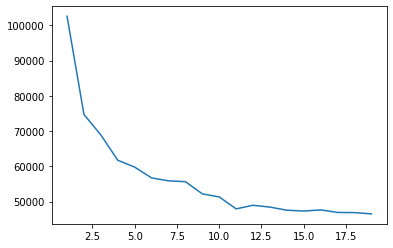

In [64]:
inertia = []
for num_clusters in range(1, 20):
    kmodes = KModes(n_clusters=num_clusters, init="Cao", n_init=1, verbose=0).fit(cat_train_df)
    inertia.append(kmodes.cost_)
    
# Plotting data.
plt.plot(np.arange(1, 20), inertia)

Lets take a K = 4 as a possible elbow point.